# Business Goal: To find features that are important for determining the
# demand for shared bikes and how well they describe the demand

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Reading and understanding the data
### Changing the datatypes of some columns, removing unnecesary columns, visualization using numerical and 
### categorical variables

In [3]:
bike=pd.read_csv("day.csv",low_memory=True)

In [4]:
bike.shape

(730, 16)

In [5]:
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
# There are 730 rows in dataframe with no null values
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
# Checking the description for each column
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [8]:
# Dropping the duplicates if any
bike.drop_duplicates(inplace=True)

In [9]:
# Rechecking the shape
bike.shape

(730, 16)

### Obs: Means there are no duplicates in the data

In [10]:
# Dropping the unnecesary columns
# Dropping instance and dteday columns as they are not needed for analysis
# Drooping registered and casual as well as they are covered in cnt which is registered+casual
# Dropping humidity
bike=bike.drop(['instant','dteday','casual','registered','hum'],axis=1)

In [11]:
# Encoding the season,weekday,month,year and weathersit columns for better readibility
#The dataypes of the above 4 columns would be string instead of integer hence making them categorical variables
bike.season=bike.season.map({1:'spring',2:'summer',3:'fall',4:'winter'})
bike.weekday=bike.weekday.map({0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'})
bike.mnth=bike.mnth.map({1:'Jan',2:'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'})
bike.weathersit=bike.weathersit.map({1:'Clear',2:'Misty_clouds',3:'Light_snow_rain',4:'Heavy_rain'})

In [12]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Misty_clouds,14.110847,18.18125,10.749882,985
1,spring,0,Jan,0,Sunday,0,Misty_clouds,14.902598,17.68695,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,12.522300,1600


In [13]:
bike.dtypes

season         object
yr              int64
mnth           object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
windspeed     float64
cnt             int64
dtype: object

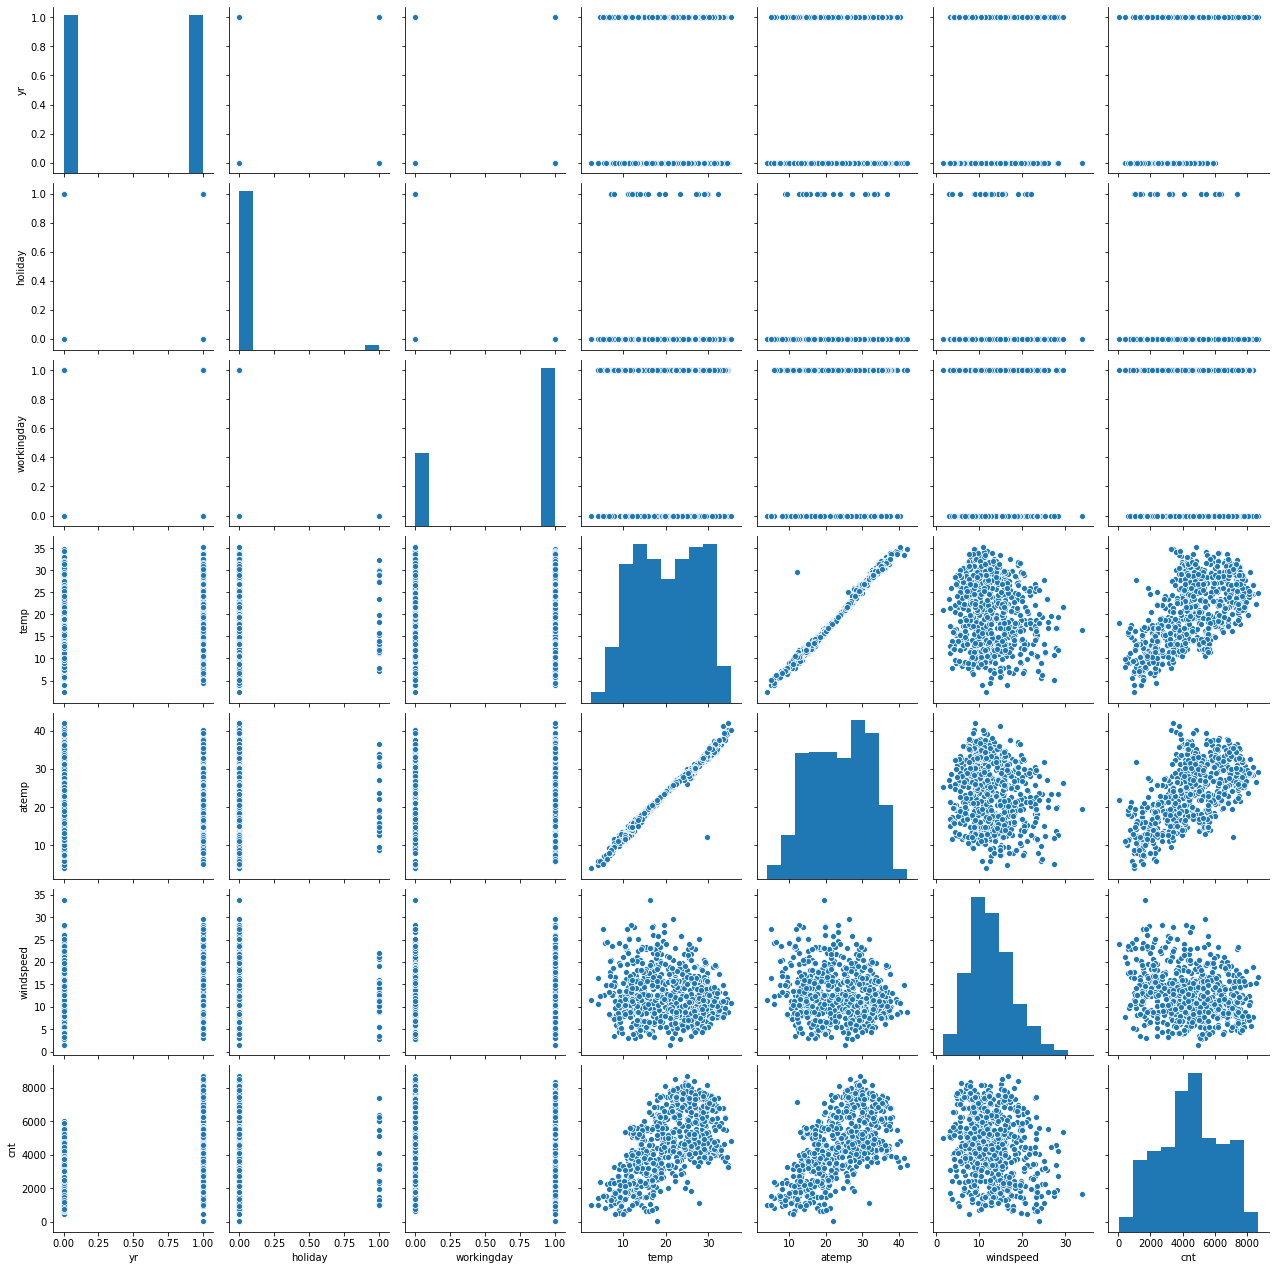

In [14]:
# Plotting for numerical columns
df=bike[['yr','holiday','workingday','temp','atemp','windspeed','cnt']]
sns.pairplot(df)
plt.show()

### Obs: A spreadout linear relation is seen between count and temp and atemp variables

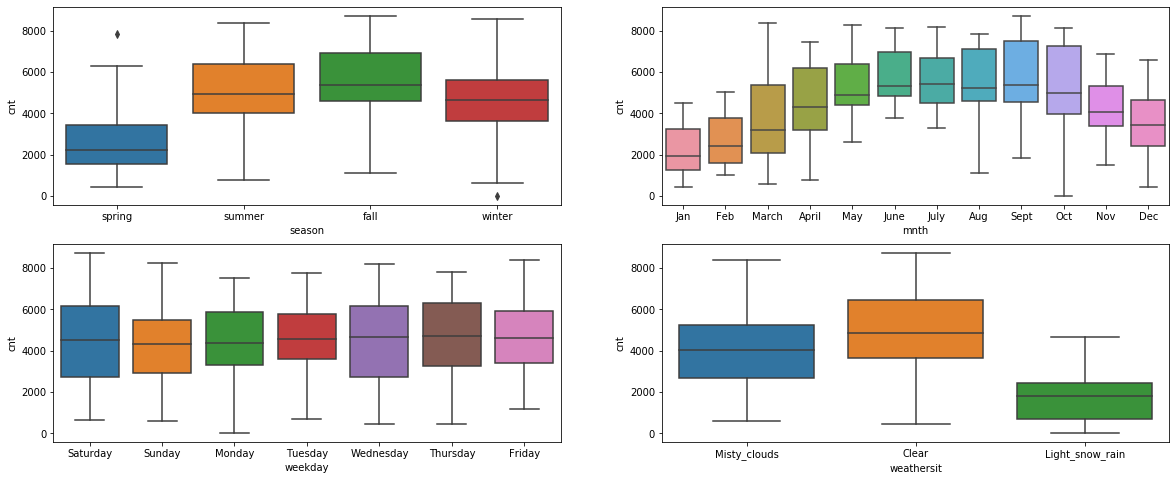

In [15]:
# Visualizing using categorical variables
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.boxplot(x='season',y='cnt',data=bike)
plt.subplot(2,2,2)
sns.boxplot(x='mnth',y='cnt',data=bike)
plt.subplot(2,2,3)
sns.boxplot(x='weekday',y='cnt',data=bike)
plt.subplot(2,2,4)
sns.boxplot(x='weathersit',y='cnt',data=bike)
plt.show()

### Obs: 
### The total customer count is highest in fall season folloed by summer and is lowest in spring.
### The customer count thus is highest in September and October ie in fall. The bookings have steadily increased in first 6 months followed by a sharp dip after October due to onset of winter season.
### There is not much difference in customer count throughout the week as the average customer count is almost same as seen in 3rd plot.
### The customer count is highest in clear weather and lowest when there is snow.

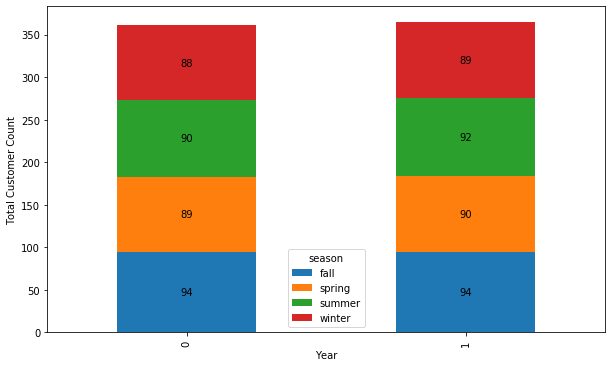

In [16]:
# Checking the distribution year wise
# To observe the impact of grade on loan status
gr=pd.pivot_table(data=bike,values='cnt',index='yr',columns='season',aggfunc=lambda x: len(x.unique()))
#gr.plot(kind='bar',stacked=True,figsize=[10,6])
ax = gr.plot.bar(stacked=True,figsize=[10,6])
labels = [i for i in gr.to_numpy().flatten(order='F')]

for i, patch in enumerate(ax.patches):
    x, y = patch.get_xy()
    x += patch.get_width() / 2
    y += patch.get_height() / 2
    ax.annotate(labels[i], (x, y), ha='center', va='center', c='black')
plt.xlabel("Year")
plt.ylabel("Total Customer Count")
plt.show()

### Obs: The total customer count does not change much in each season for 2018 and 2019. However the total number of customers is higher in 2019

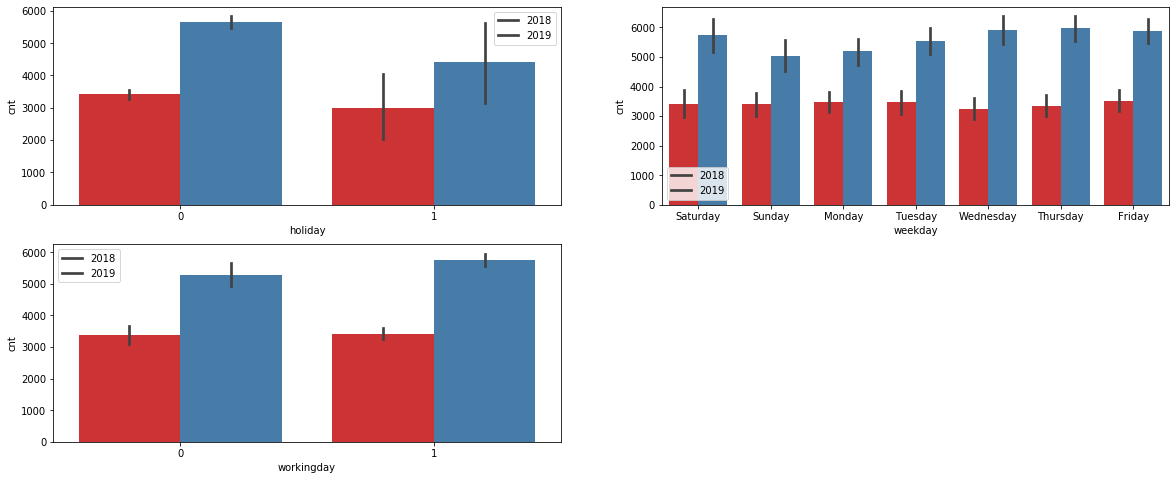

In [17]:
# Checking for weekday, working day and holiday
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.barplot('holiday','cnt',data=bike, hue='yr',palette='Set1')
plt.legend(labels=['2018', '2019'])
plt.subplot(2,2,2)
sns.barplot('weekday','cnt',data=bike, hue='yr',palette='Set1')
plt.legend(labels=['2018', '2019'])
plt.subplot(2,2,3)
sns.barplot('workingday','cnt',data=bike, hue='yr',palette='Set1')
plt.legend(labels=['2018', '2019'])
plt.show()

### Obs: The bookings are higher when it is not a holiday as when on holidays, people might be at home or may be traveling . The bookings have significantly reduced in 2019 for the same.
### Bookings have signnificantly increased in weekdays in 2019 with higher bookings in the second half of the week.
### The bookings have increased in working days in 2019.

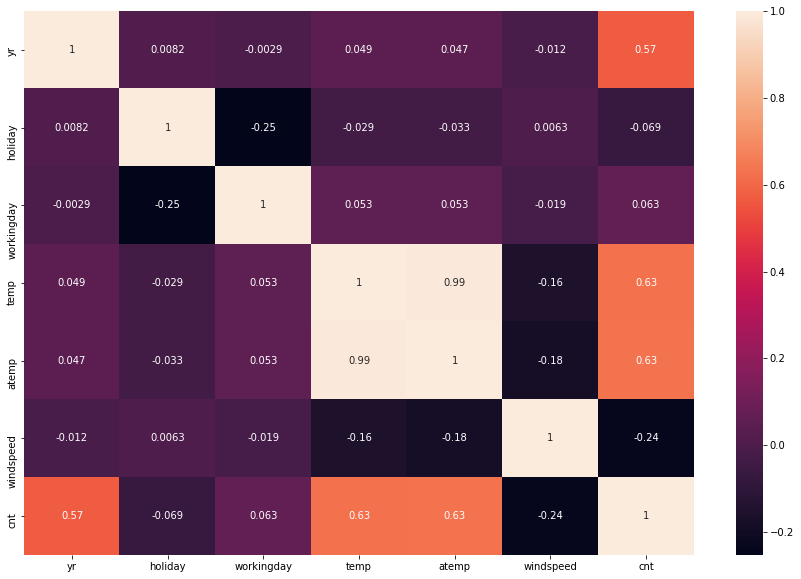

In [18]:
# Checking for correlated fields by plotting heat map
plt.figure(figsize=(15,10))
sns.heatmap(bike.corr(),annot=True)
plt.show()

### Obs: Cnt has high correlation with temp (0.63) and yr(0.57)

In [19]:
# Data Preparation
# Dummy variable creation for month, weekday, weathersit and season variables.

months_df=pd.get_dummies(bike.mnth,drop_first=True)
weekdays_df=pd.get_dummies(bike.weekday,drop_first=True)
weathersit_df=pd.get_dummies(bike.weathersit,drop_first=True)
seasons_df=pd.get_dummies(bike.season,drop_first=True)

In [20]:
# Concatenating the dummy variables with original dataset
bike=pd.concat([bike,months_df,weekdays_df,weathersit_df,seasons_df],axis=1)

In [21]:
# Dropping mnth,weekday,weathersit,atemp and season columns
# Dropping atemp as temp is highly correlated with atemp
bike=bike.drop(['mnth','weekday','weathersit','season','atemp'],axis=1)

In [22]:
bike.head()

,yr,holiday,workingday,temp,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,March,May,Nov,Oct,Sept,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_snow_rain,Misty_clouds,spring,summer,winter
0,0,0,0,14.110847,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
1,0,0,0,14.902598,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
2,0,0,1,8.050924,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,1,9.305237,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [23]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               730 non-null    int64  
 1   holiday          730 non-null    int64  
 2   workingday       730 non-null    int64  
 3   temp             730 non-null    float64
 4   windspeed        730 non-null    float64
 5   cnt              730 non-null    int64  
 6   Aug              730 non-null    uint8  
 7   Dec              730 non-null    uint8  
 8   Feb              730 non-null    uint8  
 9   Jan              730 non-null    uint8  
 10  July             730 non-null    uint8  
 11  June             730 non-null    uint8  
 12  March            730 non-null    uint8  
 13  May              730 non-null    uint8  
 14  Nov              730 non-null    uint8  
 15  Oct              730 non-null    uint8  
 16  Sept             730 non-null    uint8  
 17  Monday          

## 2. Splitting the data into test and train data

In [24]:
# Taking the train-test split as 70:30
bike_train,bike_test=train_test_split(bike,train_size=0.7,random_state=100)

In [25]:
# Scaling the data using Min-Max scaler
# Considering numerical variables except the dummy variables and the ones having 0 and 1 as value

scaler=MinMaxScaler()

num=['temp','windspeed','cnt','yr','holiday','workingday']

#Fit and transform the numerical data
bike_train[num]=scaler.fit_transform(bike_train[num])
bike_train.head()

,yr,holiday,workingday,temp,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,March,May,Nov,Oct,Sept,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_snow_rain,Misty_clouds,spring,summer,winter
576,1.0,0.0,1.0,0.815169,0.264686,0.827658,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
426,1.0,0.0,0.0,0.442393,0.255342,0.465255,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
728,1.0,0.0,0.0,0.245101,0.663106,0.204096,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
482,1.0,0.0,0.0,0.395666,0.188475,0.482973,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
111,0.0,0.0,1.0,0.345824,0.380981,0.191095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


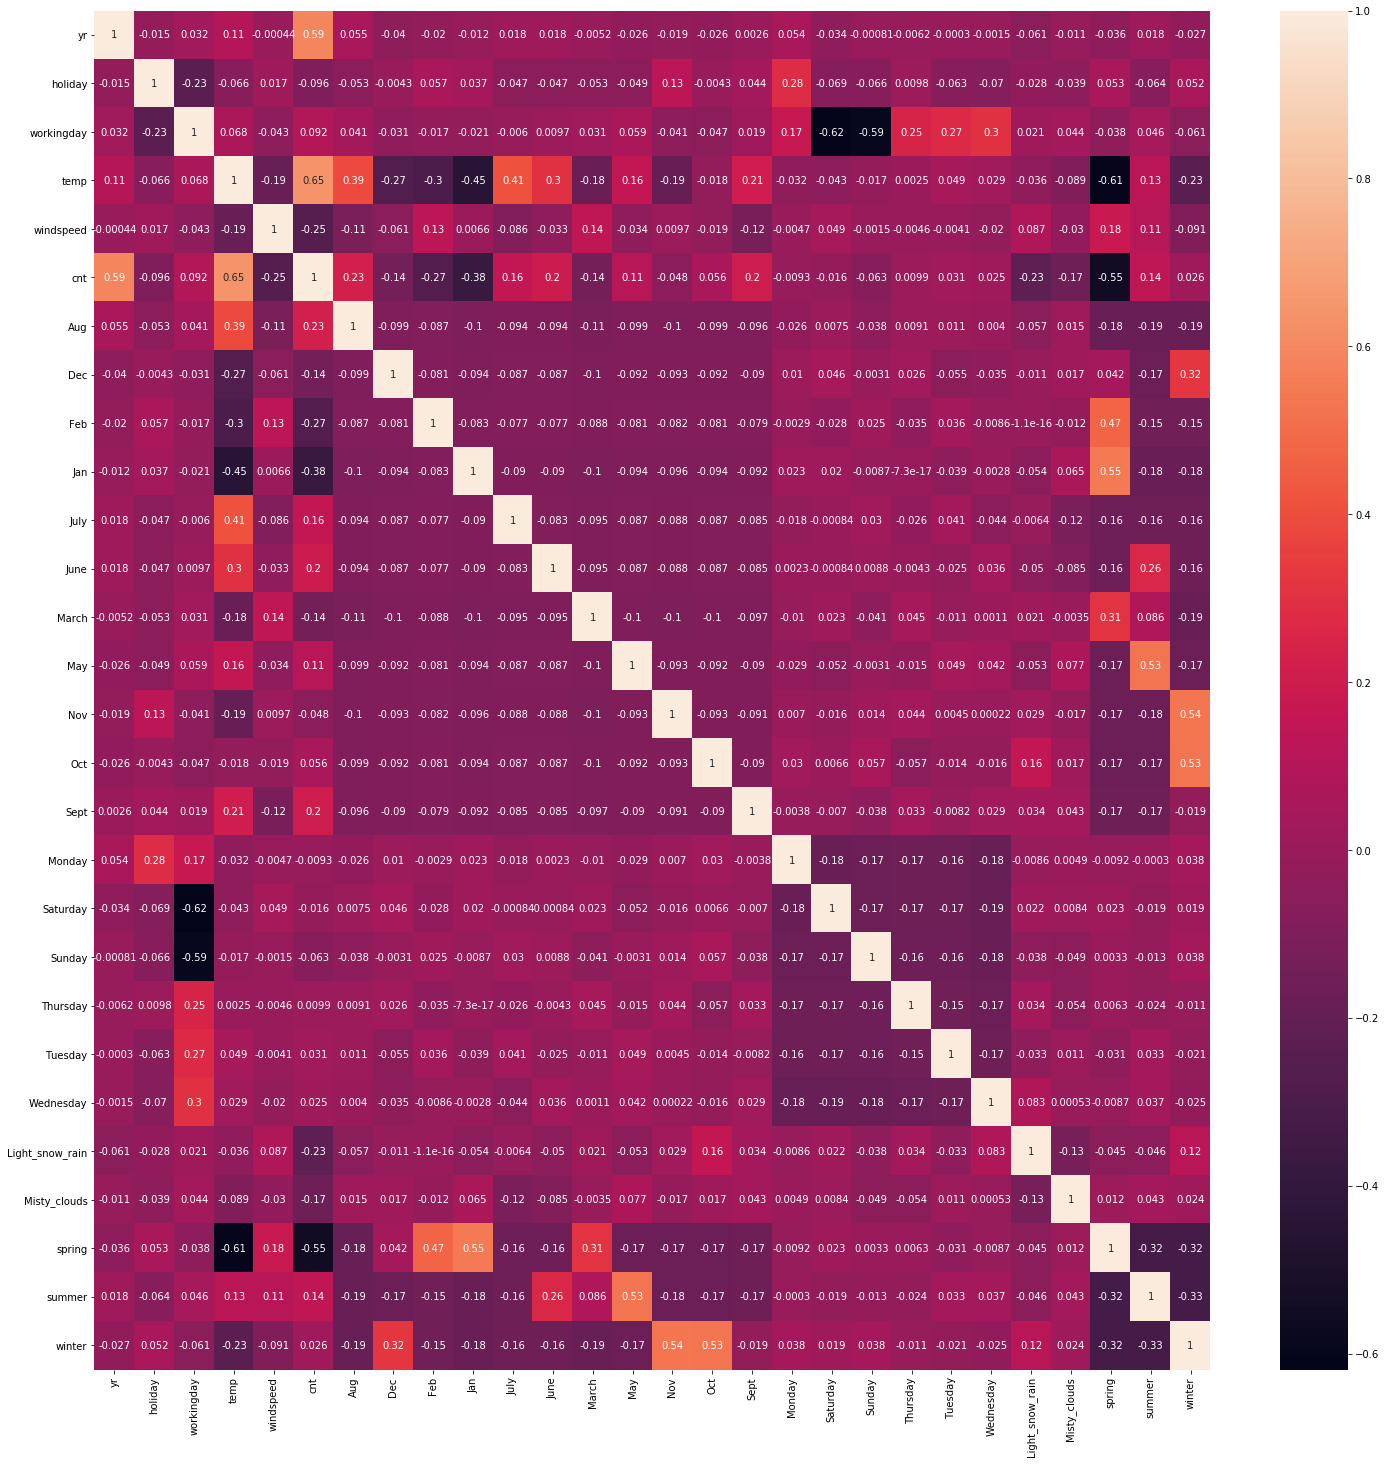

In [26]:
# Checking for correlated fields
plt.figure(figsize=(25,25))
sns.heatmap(bike_train.corr(),annot=True)
plt.show()

### cnt is highly correlated with temp and yr

In [27]:
# Since cnt is the target variable that would be our y_train and x_train would be all columns except x_train
y_train=bike_train.pop('cnt')
x_train=bike_train

In [28]:
y_train.head()

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64

In [29]:
x_train.head()

,yr,holiday,workingday,temp,windspeed,Aug,Dec,Feb,Jan,July,June,March,May,Nov,Oct,Sept,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_snow_rain,Misty_clouds,spring,summer,winter
576,1.0,0.0,1.0,0.815169,0.264686,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
426,1.0,0.0,0.0,0.442393,0.255342,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
728,1.0,0.0,0.0,0.245101,0.663106,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
482,1.0,0.0,0.0,0.395666,0.188475,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
111,0.0,0.0,1.0,0.345824,0.380981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [30]:
x_train.shape

(510, 27)

## 3. Model Building
## Using RFE (Recursive Feature elimination) and manual intervention (if needed) for model building (Selecting final list of features for model)
## Using scikitlearn for feature selection and statsmodel for further analysis

In [31]:
# Considering number of output variables as 14

# Building the model and fitting the training set to the model
lm=LinearRegression()
lm.fit(x_train,y_train)

# Passing the model instance to RFE and fitting the model
rfe=RFE(lm,14) 
rfe=rfe.fit(x_train,y_train)

In [32]:
# To check which features have been selcted by RFE and to see the importance of each feature using their rank
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 2),
 ('temp', True, 1),
 ('windspeed', True, 1),
 ('Aug', False, 6),
 ('Dec', True, 1),
 ('Feb', False, 3),
 ('Jan', True, 1),
 ('July', True, 1),
 ('June', False, 7),
 ('March', False, 14),
 ('May', False, 5),
 ('Nov', True, 1),
 ('Oct', False, 13),
 ('Sept', True, 1),
 ('Monday', False, 9),
 ('Saturday', True, 1),
 ('Sunday', False, 8),
 ('Thursday', False, 11),
 ('Tuesday', False, 10),
 ('Wednesday', False, 12),
 ('Light_snow_rain', True, 1),
 ('Misty_clouds', True, 1),
 ('spring', True, 1),
 ('summer', False, 4),
 ('winter', True, 1)]

In [33]:
# Selecting the features from RFE model
col=x_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'windspeed', 'Dec', 'Jan', 'July', 'Nov',
       'Sept', 'Saturday', 'Light_snow_rain', 'Misty_clouds', 'spring',
       'winter'],
      dtype='object')

### Using statsmodel to get detailed statistics for the 14 features

In [34]:
# Creating training dataset wth the 14 features from RFE
x_train_rfe=x_train[col]

In [35]:
# Adding a constant
x_train_rfe=sm.add_constant(x_train_rfe)

In [36]:
# Running the linear model
lm=sm.OLS(y_train,x_train_rfe).fit()

In [37]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     183.7
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.16e-185
Time:                        15:37:46   Log-Likelihood:                 503.93
No. Observations:                 510   AIC:                            -977.9
Df Residuals:                     495   BIC:                            -914.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2871      0.025     11.320      0.000       0.237       0.337
yr                  0.2355      0.008     28.762      0.000       0.219       0.252
holiday            -0.0878      0.026     -3.355      0.001      -0.139      -0.036
temp                0.4026      0.032     12.412      0.000       0.339       0.466
windspeed          -0.1560      0.025     -6.179      0.000      -0.206      -0.106
Dec                -0.0506      0.018     -2.889      0.004      -0.085      -0.016
Jan                -0.0562      0.018     -3.079      0.002      -0.092      -0.020
July               -0.0653      0.017     -3.759      0.000      -0.099      -0.031
Nov                -0.0464      0.019     -2.458      0.014      -0.084      -0.009
Sept                0.0531      0.016      3.373      0.001       0.022       0.084
Saturday            0.0203      0.011      1.806      0.071      -0.002       0.042
Light_snow_rain    -0.2944      0.025    -11.933      0.000      -0.343      -0.246
Misty_clouds       -0.0798      0.009     -9.156      0.000      -0.097      -0.063
spring             -0.1046      0.016     -6.699      0.000      -0.135      -0.074
winter              0.0616      0.014      4.331      0.000       0.034       0.090
==============================================================================
Omnibus:                       76.397   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.789
Skew:                          -0.766   Prob(JB):                     6.14e-42
Kurtosis:                       5.566   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# We are supposed to drop columns with high P value
# We can calculate VIF (Variance Inflation Factor) value as well and use VIF and P value to determine the columns to be dropped
# We will drop the columns with High p (>=0.05) and high VIF value (>5)

In [39]:
# Dropping const column as it is not a feature
x_train_new=x_train_rfe.drop('const',axis=1)

In [40]:
vif = pd.DataFrame()
X = x_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.71
3,windspeed,4.08
13,winter,2.56
12,spring,2.37
0,yr,2.07
7,Nov,1.81
5,Jan,1.65
11,Misty_clouds,1.54
4,Dec,1.47
6,July,1.36


In [41]:
# Dropping Saturday as it has high p value
x_train_new=x_train_new.drop('Saturday',axis=1)
vif = pd.DataFrame()
X = x_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.67
3,windspeed,4.05
12,winter,2.55
11,spring,2.36
0,yr,2.06
7,Nov,1.81
5,Jan,1.65
10,Misty_clouds,1.54
4,Dec,1.46
6,July,1.36


In [42]:
# Building the 2nd linear regression model
x_train_lm2 = sm.add_constant(x_train_new)
lm_2 = sm.OLS(y_train,x_train_lm2).fit()
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     196.6
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          4.08e-186
Time:                        15:37:47   Log-Likelihood:                 502.26
No. Observations:                 510   AIC:                            -976.5
Df Residuals:                     496   BIC:                            -917.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2899      0.025     11.426      0.000       0.240       0.340
yr                  0.2350      0.008     28.656      0.000       0.219       0.251
holiday            -0.0911      0.026     -3.483      0.001      -0.143      -0.040
temp                0.4019      0.033     12.363      0.000       0.338       0.466
windspeed          -0.1537      0.025     -6.082      0.000      -0.203      -0.104
Dec                -0.0496      0.018     -2.828      0.005      -0.084      -0.015
Jan                -0.0556      0.018     -3.042      0.002      -0.092      -0.020
July               -0.0647      0.017     -3.720      0.000      -0.099      -0.031
Nov                -0.0469      0.019     -2.476      0.014      -0.084      -0.010
Sept                0.0534      0.016      3.387      0.001       0.022       0.084
Light_snow_rain    -0.2939      0.025    -11.885      0.000      -0.342      -0.245
Misty_clouds       -0.0798      0.009     -9.126      0.000      -0.097      -0.063
spring             -0.1046      0.016     -6.684      0.000      -0.135      -0.074
winter              0.0621      0.014      4.351      0.000       0.034       0.090
==============================================================================
Omnibus:                       69.994   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.054
Skew:                          -0.690   Prob(JB):                     2.93e-40
Kurtosis:                       5.582   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# Dropping December as it has high p value
x_train_new=x_train_new.drop('Dec',axis=1)
vif = pd.DataFrame()
X = x_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.65
3,windspeed,4.05
10,spring,2.25
0,yr,2.06
11,winter,1.92
4,Jan,1.60
6,Nov,1.59
9,Misty_clouds,1.53
5,July,1.36
7,Sept,1.21


In [44]:
# Building the 3rd linear regression model
x_train_lm3 = sm.add_constant(x_train_new)
lm_3 = sm.OLS(y_train,x_train_lm3).fit()
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     209.4
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.43e-185
Time:                        15:37:47   Log-Likelihood:                 498.18
No. Observations:                 510   AIC:                            -970.4
Df Residuals:                     497   BIC:                            -915.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2707      0.025     10.996      0.000       0.222       0.319
yr                  0.2351      0.008     28.461      0.000       0.219       0.251
holiday            -0.0923      0.026     -3.505      0.000      -0.144      -0.041
temp                0.4259      0.032     13.479      0.000       0.364       0.488
windspeed          -0.1463      0.025     -5.782      0.000      -0.196      -0.097
Jan                -0.0437      0.018     -2.439      0.015      -0.079      -0.008
July               -0.0685      0.017     -3.924      0.000      -0.103      -0.034
Nov                -0.0266      0.018     -1.507      0.132      -0.061       0.008
Sept                0.0565      0.016      3.563      0.000       0.025       0.088
Light_snow_rain    -0.2885      0.025    -11.621      0.000      -0.337      -0.240
Misty_clouds       -0.0792      0.009     -9.003      0.000      -0.097      -0.062
spring             -0.1051      0.016     -6.672      0.000      -0.136      -0.074
winter              0.0487      0.014      3.592      0.000       0.022       0.075
==============================================================================
Omnibus:                       61.598   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.159
Skew:                          -0.634   Prob(JB):                     6.73e-33
Kurtosis:                       5.317   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# Dropping November as it has high p value
x_train_new=x_train_new.drop('Nov',axis=1)
vif = pd.DataFrame()
X = x_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.63
3,windspeed,4.01
9,spring,2.24
0,yr,2.06
4,Jan,1.60
8,Misty_clouds,1.53
10,winter,1.39
5,July,1.36
6,Sept,1.20
7,Light_snow_rain,1.08


In [46]:
# Building the 4th linear regression model
x_train_lm4 = sm.add_constant(x_train_new)
lm_4 = sm.OLS(y_train,x_train_lm4).fit()
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     227.7
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          2.87e-186
Time:                        15:37:47   Log-Likelihood:                 497.01
No. Observations:                 510   AIC:                            -970.0
Df Residuals:                     498   BIC:                            -919.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2671      0.025     10.886      0.000       0.219       0.315
yr                  0.2350      0.008     28.415      0.000       0.219       0.251
holiday            -0.0972      0.026     -3.712      0.000      -0.149      -0.046
temp                0.4316      0.031     13.743      0.000       0.370       0.493
windspeed          -0.1480      0.025     -5.848      0.000      -0.198      -0.098
Jan                -0.0431      0.018     -2.402      0.017      -0.078      -0.008
July               -0.0694      0.017     -3.972      0.000      -0.104      -0.035
Sept                0.0583      0.016      3.683      0.000       0.027       0.089
Light_snow_rain    -0.2867      0.025    -11.549      0.000      -0.336      -0.238
Misty_clouds       -0.0787      0.009     -8.938      0.000      -0.096      -0.061
spring             -0.1027      0.016     -6.545      0.000      -0.134      -0.072
winter              0.0408      0.013      3.259      0.001       0.016       0.065
==============================================================================
Omnibus:                       58.688   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.828
Skew:                          -0.612   Prob(JB):                     1.18e-30
Kurtosis:                       5.233   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Dropping January as it has high p value
x_train_new=x_train_new.drop('Jan',axis=1)
vif = pd.DataFrame()
X = x_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,4.61
3,windspeed,4.00
0,yr,2.06
8,spring,1.64
7,Misty_clouds,1.52
9,winter,1.39
4,July,1.35
5,Sept,1.20
6,Light_snow_rain,1.08
1,holiday,1.04


In [48]:
# Building the 5th linear regression model
x_train_lm5 = sm.add_constant(x_train_new)
lm_5 = sm.OLS(y_train,x_train_lm5).fit()
lm_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     247.5
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          3.10e-186
Time:                        15:37:48   Log-Likelihood:                 494.07
No. Observations:                 510   AIC:                            -966.1
Df Residuals:                     499   BIC:                            -919.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2531      0.024     10.569      0.000       0.206       0.300
yr                  0.2342      0.008     28.210      0.000       0.218       0.251
holiday            -0.0980      0.026     -3.727      0.000      -0.150      -0.046
temp                0.4498      0.031     14.686      0.000       0.390       0.510
windspeed          -0.1395      0.025     -5.540      0.000      -0.189      -0.090
July               -0.0729      0.018     -4.167      0.000      -0.107      -0.039
Sept                0.0573      0.016      3.606      0.000       0.026       0.089
Light_snow_rain    -0.2855      0.025    -11.445      0.000      -0.334      -0.236
Misty_clouds       -0.0796      0.009     -9.014      0.000      -0.097      -0.062
spring             -0.1123      0.015     -7.360      0.000      -0.142      -0.082
winter              0.0449      0.012      3.602      0.000       0.020       0.069
==============================================================================
Omnibus:                       57.674   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.692
Skew:                          -0.599   Prob(JB):                     2.08e-30
Kurtosis:                       5.235   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The F statistic is high 247.5 and probability (F statistic) is very low ie 3.1 * e-186 showing that the model is significant

## 4. Residual Analysis

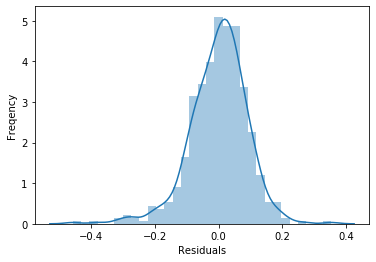

In [49]:
y_train_cnt=lm_2.predict(x_train_lm2)
residual=y_train-y_train_cnt
sns.distplot(residual)
plt.xlabel('Residuals')
plt.ylabel("Freqency")
plt.show()

### Obs:
### The residuals have a normal distribution and they are centred at 0.
### The plot is tailed at 0.4

## 5. Making Predictions

In [50]:
# Create list of numeric variables for testing data
num = ['temp','windspeed','cnt','yr','holiday','workingday']

#Fit and transform the numerical data
bike_test[num]=scaler.transform(bike_test[num])
bike_test.head()

,yr,holiday,workingday,temp,windspeed,cnt,Aug,Dec,Feb,Jan,July,June,March,May,Nov,Oct,Sept,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_snow_rain,Misty_clouds,spring,summer,winter
184,0.0,1.0,0.0,0.831783,0.084219,0.692706,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
535,1.0,0.0,1.0,0.901354,0.153728,0.712034,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
299,0.0,0.0,1.0,0.511964,0.334206,0.303382,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
221,0.0,0.0,1.0,0.881625,0.339570,0.547400,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
152,0.0,0.0,1.0,0.817246,0.537414,0.569029,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [51]:
y_test=bike_test.pop('cnt')
x_test=bike_test

In [52]:
# Make prediction
x_test_new=x_test[x_train_new.columns]
x_test_new=sm.add_constant(x_test_new)

In [53]:
y_pred=lm_5.predict(x_test_new)

## 6. Validation of model

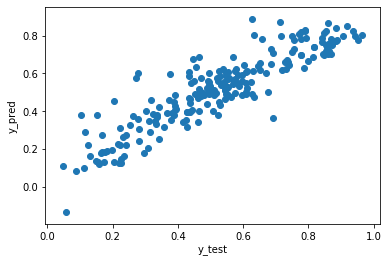

In [54]:
plt.scatter(y_test,y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred') 
plt.show()

### Homoscedasticity

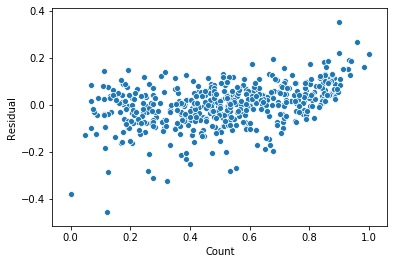

In [55]:
sns.scatterplot(y_train,residual)
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

### Obs: There is no pattern between the residuals

### The final equation of the model

In [56]:
round(lm_5.params,3)

const              0.253
yr                 0.234
holiday           -0.098
temp               0.450
windspeed         -0.140
July              -0.073
Sept               0.057
Light_snow_rain   -0.285
Misty_clouds      -0.080
spring            -0.112
winter             0.045
dtype: float64

### The model is represented by the equation: cnt=0.234*(yr)-0.098*(holiday)+0.450*(temp)-0.14*(windspeed)-0.073*(July)+0.057*(Sept)-0.285*(Light_snow_rain)-0.08*Misty_clouds-0.112*(spring)+0.045*(winter)+0.253  

### The count of the total rental bikes booked depends on the following features:
### 1. year in which the booking was done
### 2. whether the booking day is a holiday or not
### 3. temp on the day of booking
### 4. the windspeed
### 5. July,Sept
### 6. The weather
### 7. The season

## 7. Calculating R^2 for testing dataset

In [57]:
round(r2_score(y_test, y_pred),3)

0.807

## 8. Adjusted R^2 for training dataset

In [58]:
round(1-(1-round(r2_score(y_test, y_pred),3))*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1),3)

0.78

## 9. Plotting regression plot

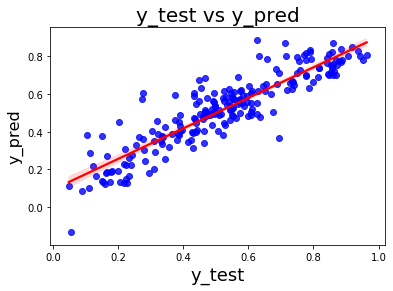

In [59]:
plt.figure()
sns.regplot(x=y_test, y=y_pred,fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)
plt.show()

## Values for Training and Testing Dataset

Training Dataset:                              
R^2: 0.832                              
Adjusted R^2: 0.829                     

Testing Dataset:
R^2: 0.807    
Adjusted R^2: 0.78